In [154]:
# semantic feature visualization based on customized input t
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math

from exp_synthetic_dataset.utils.vis import plot_loss, imsave, Logger, imsave_inp
from exp_synthetic_dataset.utils.simple_vae import VAE

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pandas as pd
import seaborn as sns


sys.path.append(".")



In [155]:
# load the trained model with confounder correction------------------------

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Model
model = VAE(device=device).to(device)
model_lr = torch.nn.Linear(1,1).to(device)
try:
    model.load_state_dict(torch.load("exp_synthetic_dataset/trained_models/ours_with_VAE.pth"))
except:
    print("Invalid weight path.")


try:
    model_lr.load_state_dict(torch.load("exp_synthetic_dataset/trained_models/ours_with_LR.pth"))
except:
    print("Invalid weight path.")
    
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [156]:
input_t_list = [0.2, 0.25, 0.30, 0.35 , 0.4, 0.5 , 0.6 , 0.7, 0.75, 0.8, 0.85] #customized input 11 values of t
input_t_list_tensor = torch.from_numpy(np.array(input_t_list)).to(device) #
value_ki_list = []
rec_tensors = torch.zeros((11,1, 64, 64))
for i in range(11):
    input_t = input_t_list[i]
    
    with torch.no_grad():
        model.train(False)
        
        d_mean = np.array([0.15, 0.15], dtype=np.float32)  # Use float32 for compatibility
        d_mean_tensor = torch.from_numpy(d_mean).to(device)


        flag_sampling = 1
        value_ki = 0.03
        loop_count = 0
        while flag_sampling and loop_count < 10000:      # loop while err < 0.001, within 10000 iterations
            loop_count = loop_count + 1
            sampled_point = d_mean_tensor + value_ki * model.pe.weight # model.pe.weight is the vector p in manuscript 
            sampled_zp = model.pe(sampled_point)
            predicted_t = model_lr(sampled_zp)
            #print(middle_project_right)
            if torch.abs(input_t-predicted_t) < 0.001:
                break
            if input_t-predicted_t < 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                value_ki = value_ki - 0.001 
            else:
                value_ki = value_ki + 0.001

        value_ki_list = np.append(value_ki_list,value_ki)

        sampled_point = d_mean_tensor +  value_ki* model.pe.weight 
        sampled_zp = model.pe(sampled_point)
        predicted_t = model_lr(sampled_zp)
        print('The predicted brightness of frame',i+1, predicted_t.item())
        rec_tensors[i] = model.decode(sampled_point)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


 


The predicted brightness of frame 1 0.20093955099582672
The predicted brightness of frame 2 0.25099456310272217
The predicted brightness of frame 3 0.30087271332740784
The predicted brightness of frame 4 0.3509277403354645
The predicted brightness of frame 5 0.4009827673435211
The predicted brightness of frame 6 0.5009159445762634
The predicted brightness of frame 7 0.5990804433822632
The predicted brightness of frame 8 0.6990135908126831
The predicted brightness of frame 9 0.7490686774253845
The predicted brightness of frame 10 0.7991237044334412
The predicted brightness of frame 11 0.8490018248558044


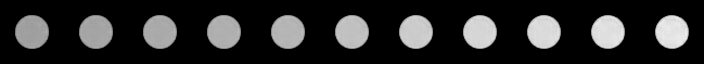

[0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85]

In [157]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png"))
display(image)
#displace the 11 frames of reconstrected images, corresponding to the 11 input values of t:
[0.2, 0.25, 0.30, 0.35 , 0.4, 0.5 , 0.6 , 0.7, 0.75, 0.8, 0.85]

In [158]:
# load the trained model without confounder correction------------------------

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Model
model = VAE(device=device).to(device)
model_lr = torch.nn.Linear(1,1).to(device)
try:
    model.load_state_dict(torch.load("exp_synthetic_dataset/trained_models/ours_without_VAE.pth"))
except:
    print("Invalid weight path.")


try:
    model_lr.load_state_dict(torch.load("exp_synthetic_dataset/trained_models/ours_without_LR.pth"))
except:
    print("Invalid weight path.")
    
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [159]:
input_t_list = [0.2, 0.25, 0.30, 0.35 , 0.4, 0.5 , 0.6 , 0.7, 0.75, 0.8, 0.85] 
#customized input value of t, same as above

input_t_list_tensor = torch.from_numpy(np.array(input_t_list)).to(device) 
value_ki_list = []
rec_tensors = torch.zeros((11,1, 64, 64))
for i in range(11):
    input_t = input_t_list[i]
    
    with torch.no_grad():
        model.train(False)
        
        d_mean = np.array([0.15, 0.15], dtype=np.float32)  # Use float32 for compatibility
        d_mean_tensor = torch.from_numpy(d_mean).to(device)


        flag_sampling = 1
        value_ki = 0.03
        loop_count = 0
        while flag_sampling and loop_count < 10000:      # loop while err < 0.001
            loop_count = loop_count + 1
            sampled_point = d_mean_tensor + value_ki * model.pe.weight # model.pe.weight is the vector p in manuscript 
            sampled_zp = model.pe(sampled_point)
            predicted_t = model_lr(sampled_zp)
            #print(middle_project_right)
            if torch.abs(input_t-predicted_t) < 0.001:
                break
            if input_t-predicted_t < 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                value_ki = value_ki - 0.001 
            else:
                value_ki = value_ki + 0.001

        value_ki_list = np.append(value_ki_list,value_ki)

        sampled_point = d_mean_tensor +  value_ki* model.pe.weight 
        sampled_zp = model.pe(sampled_point)
        predicted_t = model_lr(sampled_zp)
        print('The predicted brightness of frame',i+1, predicted_t.item())
        rec_tensors[i] = model.decode(sampled_point)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


 


The predicted brightness of frame 1 0.20092053711414337
The predicted brightness of frame 2 0.250936359167099
The predicted brightness of frame 3 0.30095216631889343
The predicted brightness of frame 4 0.35096797347068787
The predicted brightness of frame 5 0.4009837806224823
The predicted brightness of frame 6 0.5009247660636902
The predicted brightness of frame 7 0.5990536212921143
The predicted brightness of frame 8 0.6990852355957031
The predicted brightness of frame 9 0.7490105032920837
The predicted brightness of frame 10 0.7990262508392334
The predicted brightness of frame 11 0.8490420579910278


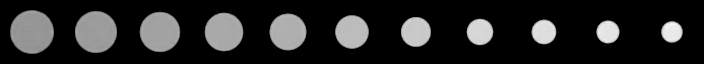

[0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85]

In [160]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png")) 
display(image)
#displace the 11 frames of reconstrected images, corresponding to the 11 input values of t:
[0.2, 0.25, 0.30, 0.35 , 0.4, 0.5 , 0.6 , 0.7, 0.75, 0.8, 0.85]